In [0]:
!wget -q https://download.pytorch.org/tutorial/data.zip
!unzip -q data.zip
!rm data.zip

In [0]:
import glob 
import unicodedata
import string 
import os 
import torch 

def findFiles(filepath): return glob.glob(filepath)

print(findFiles('data/names/*.txt'))

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters) + 1

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn' 
      and c in all_letters
  )

print(unicodeToAscii('đau để trưởng thành.'))

category_lines = {}
all_categories = []

def readlines(filename):
  lines = open(filename, encoding='utf8').read().strip().split('\n')
  return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  lines = readlines(filename)
  category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Greek.txt', 'data/names/Vietnamese.txt', 'data/names/German.txt', 'data/names/Dutch.txt', 'data/names/Irish.txt', 'data/names/Scottish.txt', 'data/names/Chinese.txt', 'data/names/French.txt', 'data/names/Czech.txt', 'data/names/Italian.txt', 'data/names/Russian.txt', 'data/names/Korean.txt', 'data/names/Arabic.txt', 'data/names/Portuguese.txt', 'data/names/Japanese.txt', 'data/names/Spanish.txt', 'data/names/Polish.txt', 'data/names/English.txt']
au e truong thanh.


In [0]:
import torch.nn as nn 

class RNN(nn.Module):
  def __init__(self, category_size, input_size, hidden_size, output_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.i2o = nn.Linear(category_size + input_size + hidden_size, output_size)
    self.i2h = nn.Linear(category_size + input_size + hidden_size, hidden_size)
    self.o2o = nn.Linear(output_size + hidden_size, output_size)
    self.dropout = nn.Dropout(0.3)
    self.softmax = nn.LogSoftmax(dim=1)
  
  def forward(self, category, input, hidden):
    input_combined = torch.cat((category, input, hidden), 1)
    output = self.i2o(input_combined)
    hidden = self.i2h(input_combined)
    out_combined = torch.cat((output, hidden), 1)
    output = self.o2o(out_combined)
    output = self.dropout(output)
    output = self.softmax(output)
    return output, hidden
  
  def init_hidden(self):
    return torch.zeros((1, self.hidden_size)).to(device)

device = "cuda" if torch.cuda.is_available() else "cpu"

n_hidden = 128
rnn = RNN(n_categories, n_letters, n_hidden, n_letters).to(device)

In [0]:
import random 

def randomChoice(l):
  return l[random.randint(0, len(l)-1)]

def randomTrainingPair():
  category = randomChoice(all_categories)
  line = randomChoice(category_lines[category])
  return category, line

In [0]:
def letterToIndex(letter):
  return all_letters.find(letter)

def letterToTensor(letter):
  tensor = torch.zeros((1, n_letters))
  tensor[0][letterToIndex(letter)] = 1 
  return tensor.to(device)

def lineToTensor(line):
  input_tensor = torch.zeros((len(line), 1, n_letters))
  target_tensor = torch.LongTensor((len(line)))
  for li, letter in enumerate(line):
    input_tensor[li][0][letterToIndex(letter)] = 1
    if li > 0:
      target_tensor[li-1] = letterToIndex(letter)
  target_tensor[-1] = n_letters - 1
  return input_tensor, target_tensor

In [0]:
def categoryTensor(category):
  li = all_categories.index(category)
  tensor = torch.zeros((1, n_categories))
  tensor[0][li] = 1
  return tensor.to(device)

In [0]:
def randomTrainingExample():
  category, line = randomTrainingPair()
  category_tensor = categoryTensor(category)
  input_tensor, target_tensor = lineToTensor(line)
  return category_tensor.to(device), input_tensor.to(device), target_tensor.to(device)

In [0]:
criterion = nn.NLLLoss()
learning_rate = 5e-3

def train(category_tensor, input_tensor, target_tensor):
  target_tensor.unsqueeze_(-1)
  hidden = rnn.init_hidden()
  loss = 0 
  rnn.zero_grad()

  for i in range(input_tensor.size()[0]):
    output, hidden = rnn(category_tensor, input_tensor[i], hidden)
    l = criterion(output, target_tensor[i])
    loss += l

  loss.backward()

  for param in rnn.parameters():
    param.data.add_(-learning_rate, param.grad.data)

  return output, loss.item()/input_tensor.size()[0]

In [0]:
import time 

def timeSince(since):
  now = time.time()
  s = now - since 
  m = s // 60
  s -= m*60
  return ' %dm %ds ' %(m, s)

n_iters = 100000
print_every = 5000
plot_every = 1000
total_loss = 0
losses = []
start = time.time()

for iter in range(1, n_iters+1):
  category_tensor, input_tensor, target_tensor = randomTrainingExample()
  output, loss = train(category_tensor, input_tensor, target_tensor)
  total_loss += loss

  if iter % print_every == 0:
    print(f' {timeSince(start)} ({iter} {iter*100/n_iters}%) {loss}')

  if iter % plot_every == 0:
    losses.append(total_loss/plot_every)
    total_loss = 0

  0m 34s  (5000 5.0%) 1.5802613894144695
  1m 9s  (10000 10.0%) 2.048708438873291
  1m 44s  (15000 15.0%) 3.2006441752115884
  2m 19s  (20000 20.0%) 3.169278860092163
  2m 53s  (25000 25.0%) 2.6975342886788503
  3m 28s  (30000 30.0%) 2.2397493634905135
  4m 3s  (35000 35.0%) 2.549009323120117
  4m 37s  (40000 40.0%) 1.689297040303548
  5m 12s  (45000 45.0%) 2.382789929707845
  5m 47s  (50000 50.0%) 2.5367439814976285
  6m 22s  (55000 55.0%) 2.7974514961242676
  6m 56s  (60000 60.0%) 2.2597157955169678
  7m 31s  (65000 65.0%) 2.7515642166137697
  8m 5s  (70000 70.0%) 2.206803560256958
  8m 39s  (75000 75.0%) 2.729053224836077
  9m 14s  (80000 80.0%) 2.2989084720611572
  9m 49s  (85000 85.0%) 2.4284608023507253
  10m 24s  (90000 90.0%) 2.160863494873047
  10m 58s  (95000 95.0%) 2.917853355407715
  11m 34s  (100000 100.0%) 2.7847954432169595


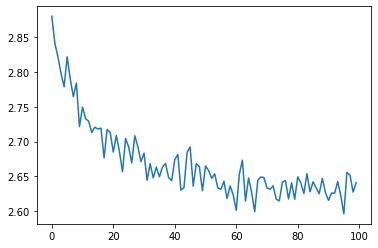

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 

plt.figure()
plt.plot(losses)

In [0]:
def sample(category, start_letter):
  with torch.no_grad():
    input_tensor = letterToTensor(start_letter)
    hidden = rnn.init_hidden()
    category_tensor = categoryTensor(category)
    results = start_letter
    while True:
      output, hidden = rnn(category_tensor, input_tensor, hidden)
      top_n, top_i = output.topk(1)
      if top_i == n_letters - 1:
        return results
      input_tensor = letterToTensor(all_letters[top_i])
      results += all_letters[top_i]

def samples(category, start_letters='ABC'):
  for start_letter in start_letters:
    print(sample(category, start_letter))

In [0]:
samples('Russian', 'RUS')

Roshuv
Usko
Shavakelov


In [0]:
samples('Japanese', 'TLN')

Tamako
Lawska
Naka


In [0]:
samples('Vietnamese', 'LT')

Lam
Tham


In [0]:
print(category_lines['Vietnamese'])

['Nguyen', 'Tron', 'Le', 'Pham', 'Huynh', 'Hoang', 'Phan', 'Vu', 'Vo', 'Dang', 'Bui', 'Do', 'Ho', 'Ngo', 'Duong', 'Ly', 'An', 'an', 'Bach', 'Banh', 'Cao', 'Chau', 'Chu', 'Chung', 'Chu', 'Diep', 'Doan', 'Dam', 'Dao', 'Dinh', 'Doan', 'Giang', 'Ha', 'Han', 'Kieu', 'Kim', 'La', 'Lac', 'Lam', 'Lieu', 'Luc', 'Luong', 'Luu', 'Ma', 'Mach', 'Mai', 'Nghiem', 'Phi', 'Pho', 'Phung', 'Quach', 'Quang', 'Quyen', 'Ta', 'Thach', 'Thai', 'Sai', 'Thi', 'Than', 'Thao', 'Thuy', 'Tieu', 'To', 'Ton', 'Tong', 'Trang', 'Trieu', 'Trinh', 'Truong', 'Van', 'Vinh', 'Vuong', 'Vuu']
